In [1]:
from pathlib import Path
import regex as re

# Text Preprocessing
We need a way to normalize all the text we've collected, while preserving our organized directory structure
 - We need a function to clean a directory of files (`preprocess_dir`).
  - This function will make a call to its helper function `preprocess_file` for each file in the directory.
  - `preprocess_file` will use `read_text` to read line by line, and make a call to `normalize_text` to clean the text in every line.

In [2]:
# take text line by line from source files
def read_text(path):
    with Path(path).open(encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line:
                yield line # yield keyword more memory and time efficient for line by line processing than returning full list of sentences all at once

In [3]:
# normalizing text - all lowercase letters, get rid of numbers and special symbols.
def normalize_text(text):
    return re.sub(r"[^\p{L}\s+]", "", text.lower())

In [4]:
# process for cleaning one file
def preprocess_file(input_path, output_path):
    with open(output_path, "w", encoding="utf-8") as output:
        for i in read_text(input_path):
            clean = normalize_text(i)
            if clean:
                output.write(clean + "\n")

In [5]:
# process for cleaning a directory
def preprocess_dir(root_dir, output_root):
    root_dir = Path(root_dir)
    output_root = Path(output_root)
    for file in root_dir.rglob("*"):
        if file.is_file():
            rel_path = file.relative_to(root_dir) # extracts relative path
            output_file = output_root / rel_path # creates a new path for the output file
            output_folder = output_file.parent
            if output_folder.exists():
                continue
            output_file.parent.mkdir(parents = True, exist_ok = True) # creates any necessary parent directories if they dont already exist, as well as suppressing an error if the parents already exist
            preprocess_file(file, output_file) 

In [6]:
# call functions to clean source directories
preprocess_dir("SOURCE", "CLEANED")

At this point, all of our text has been cleaned and stored in a new location.

In [7]:
from collections import Counter
from nltk.util import ngrams
import pickle

# N-gram tokenization
The sound profiles of each language are vectors in $R^k$ where $k$ is the number of n-grams recorded in that language.
 - Each entry in the vector is mapped to its corresponding n-gram label.
 - Sound profiles are created for each language, and stored in `language_ngram_vectors.pkl` for easy access.

In [8]:
# create ngrams of length n, do not include ngrams with newline character
def char_ngrams(text, n):
    return (''.join(i) for i in ngrams(text, n))

In [9]:
def get_freq_vector(ngrams):
    counts = Counter(ngrams) # stores the count of ngrams as key-value pairs
    total = sum(counts.values()) # total number of ngrams
    return {k: v/total for k, v in counts.items()} # returns a dictionary with each unique ngram as the key and the frequency as the value

In [10]:
# creates language vectors 
def ngram_frequencies_by_language(root_dir, n = 3):
    lang_vectors = {} # create a dictionary to store the language vectors
    root = Path(root_dir)

    for lang_dir in root.iterdir(): # iterates through the root directory
        print(lang_dir) # print statement to track progress
        if lang_dir.is_dir():
            all_text = [] # make a list to store the text
            for file in lang_dir.rglob("*"): # goes through all files inside the directory
                # appends the text in the file to the all_text list if the file is valid
                if file.is_file():
                    all_text.append(file.read_text(encoding="utf-8"))
            text = " ".join(all_text) # joins all the text together with newline characters
            ngrams = char_ngrams(text, n) # creates ngrams
            lang_vectors[lang_dir.name] = get_freq_vector(ngrams) # returns dictionary of language vectors.

    return lang_vectors # return our language vectors

In [49]:
# calling functions to actually create language vectors
vectors = ngram_frequencies_by_language("CLEANED", 3)

with open("language_ngram_vectors.pkl", "wb") as f: # write all the vectors to a pkl file
    pickle.dump(vectors, f)

CLEANED\Dutch
CLEANED\English
CLEANED\French
CLEANED\German
CLEANED\Indonesian
CLEANED\Italian
CLEANED\Portuguese
CLEANED\Romanian
CLEANED\Spanish
CLEANED\Swedish
CLEANED\Turkish
CLEANED\Vietnamese


In [50]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Dimensionality Reduction, Visualization
Lets see if we can visualize clusters of languages using the sound profiles we've created for our languages!
 - Because the sound profile vectors may be of different size for each language, we need to pool our n-grams from every language, and create a matrix in $R^{L\times K}$ where $L$ is the number of languages in our dataset, and $K$ is the number of n-grams we have across all our languages. The $ij^{th}$ entry is the frequency that the $j^{th}$ n-gram appears in the $i^{th}$ language.
 - With consistently sized row vectors, we can create a symmetric distance matrix using cosine similarities.
 - Using the distance matrix, we can create and apply a UMAP (Uniform Manifold Approximation and Projection) reducer to reduce the dimensionality of our vectors, and project them into $R^2$.
    - Our reducer uses `n_neighbors = 3` to preserve the local relationships between languages rather than global relationships - we want to see clusters within our small dataset.
 - We create an embedding of our vectors with reduced dimensionality, and using matplotlib, we create a plot to visualize the similarity/relationships between the sound profiles.

In [51]:
# load language vectors from desired file
with open("language_ngram_vectors.pkl", "rb") as f:
    lang_vectors = pickle.load(f)

# need to create a list of all unique n_grams that appear in all of our texts
all_ngrams_set = set() # start with a set to avoid duplicates

for lang_vector in lang_vectors.values(): # loop over the language vectors
    for n_gram in lang_vector: # loop over the ngrams in the language vector
        all_ngrams_set.add(n_gram) # add the ngram to the set

all_ngrams = sorted(all_ngrams_set) # convert to a sorted list (sorted for reproducibility, since sets are unordered)
names = list(lang_vectors.keys()) # list stores the names of the languages we are working with

# creates a matrix where each row corresponds to a language, each column corresponds to an ngram, and each entry is defined as the frequency of that ngram within the languages text
matrix = np.array([
    [lang_vectors[language].get(n_gram, 0.0) for n_gram in all_ngrams]
    for language in names
], dtype=float)

In [52]:
# Pairwise cosine distance
# cosine similarity = dot(a,b)/(||a||*||b||)
dot_products = matrix @ matrix.T # find dot products between each language
norms = norm(matrix, axis=1) # find norms of each vector
cosine_similarity = dot_products / np.outer(norms, norms) # compute cosine similarity
distance = np.clip(1.0 - cosine_similarity, 0.0, None)   # computes symmetric distance matrix

In [53]:
# UMAP embedding
reducer = umap.UMAP(metric="cosine", n_components=2, random_state=42, n_neighbors=3, n_jobs=1) # create a reducer using the cosine similarity metric
embedding = reducer.fit_transform(distance) # make an embedding from the reducer using our distance matrix 

# The resulting plot:
Initially, the goal was to verify that languages would cluster with the rest of the languages in its respective language family. We can see this happening with the Romance languages (Portuguese, Spanish, Italian, French, Romanian), as well as the Germanic languages (Swedish, German, Dutch), and languages that dont fall into either of these categories are clearly seperated from these clusters.

The surprising result from this plot is the placement of the English sound profile vector. English has been grouped with the Romance languages, despite its classification as a Germanic language. Linguists believe that English shares a common ancestor with other Germanic languages, but has diverged phonetically due to historical contact with the Romance languages. Due to this, English has developed a phonetic structure that resembles that of the Romance languages, hence why it was placed among this cluster.

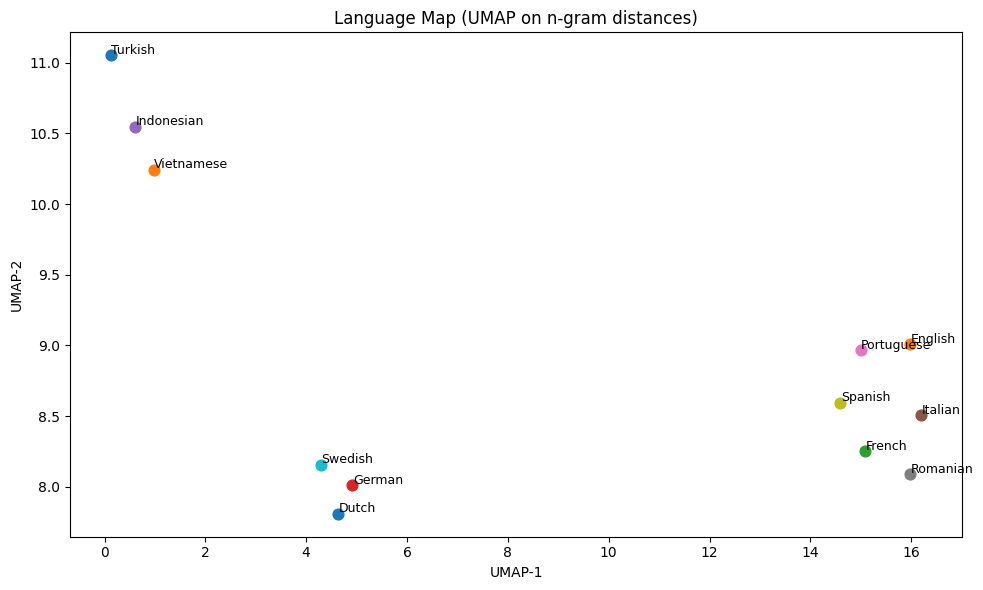

In [54]:
# plotting
plt.figure(figsize=(10, 6))
for i, lang in enumerate(names):
    x, y = embedding[i]
    plt.scatter(x, y, s=60)
    plt.text(x + 0.01, y + 0.01, lang, fontsize=9)
plt.title("Language Map (UMAP on n-gram distances)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [55]:
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy
from lightning.pytorch import LightningModule
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer
from lightning import seed_everything
import shutil, os, torch


# Language Classifier (MLP)
We are using a Lightning Module to design a simple multi-layer-perceptron.
 - We need to load our n-gram vectors first. Then, we make a dataframe to enable easier data manipulation. From there, we create a label map to convert language names to integers - so we can classify the output of our neural network and evaluate the accuracy of our model during training. We extract our feature vectors and targets from the dataframe and make a tensor dataset, and further, a dataloader for training.
 - While Lightning Modules typically split data into training data and validation data to monitor the models ability to generalize information during training, we are not performing a validation step during training of this model. In this experiment, we are not tuning any hyperparameters, and we are using a separate dataset to cross validate the model after training. Thus, a validation step during the training loop is unnecessary. If we split the data into 80% training data, and 20% validation data, the model is missing 20% of the data in each language's feature vector. With a vocabulary size of 49786 trigrams, this is almost 10000 missing datapoints. During testing, the validation step resulted in a substantial drop in classification accuracy. Our goal is to have the model learn the complete sound profile for each language, so it must be exposed to the full training set. Training on the full dataset avoids this problem, while still allowing generalization to be assessed during cross validation using the separate dataset of test sentences.
 - For the definition of our MLP Lightning Module, we define our sequential neural network with a linear layer, a ReLU activation function to introduce non-linearity, and another linear layer to map hidden features to outputs. We also create our forward-pass method, a training step, and a method to configure an optimizer.
 - Next, we create a training function to train the model as well as log any useful information and save our model once its done training.

In [56]:
with open("language_ngram_vectors.pkl", "rb") as f:
    data = pickle.load(f)

df = pd.DataFrame(data).fillna(0).T # make dataframe with ngram frequency per language - fill NA entries with 0, and take transpose.
languages = df.index.tolist() # get list of language names
label_map = {lang: i for i, lang in enumerate(languages)} # associate each language with a number

features = torch.tensor(df.values, dtype=torch.float32) # frequency values for each language
targets = torch.tensor([label_map[lang] for lang in languages], dtype=torch.int64) # numbers for each language

dataset = TensorDataset(features, targets) # convert data to a torch tensor

# Create our dataloaders - set validation dataloader to none so lightning ignores it 
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=15, persistent_workers=True)
val_dataloader = None

features.shape # num of languages, total size of n-gram vocabulary

torch.Size([12, 49786])

In [57]:
# define a simple neural network (multi layer perceptron)
class MLP_Language_Classifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    # forward pass (passes the input tensor through the layers in sequence)
    def forward(self, x):
        return self.model(x)

class Lightning_MLP_Language_Classifier(LightningModule):
    # our model will consist of a linear layer, a ReLU activation function to introduce non linearity, and another linear layer to map our hidden features to outputs
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.accuracy = Accuracy(task="multiclass",num_classes=len(list(label_map.keys())))
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, targets = batch
        y = self.forward(x)
        loss = cross_entropy(y, targets)
        self.accuracy(y,targets)
        self.log("train_loss", loss, prog_bar=True)
        self.log("accuracy", self.accuracy, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.01)


In [58]:
# training function for lightning modules
def train(*, name:str, model:LightningModule, epochs:int):
    seed_everything(0)
    # set up the lightning trainer
    logger = CSVLogger(save_dir="logs/", name=name)
    trainer = Trainer(max_epochs=epochs, logger=logger)

    # delete previous versions of the model before training new one:
    try:
        shutil.rmtree(f"./logs/{name}/")
        os.mkdirs(f"./logs/{name}")
    except:
        pass

    # train the model
    trainer.fit(model, train_dataloader, val_dataloader)

Time to finally create our model and train it. We extract the `input_dim` from our features tensor, set the `hidden_dim`, and `output_dim` to the number of languages we have. Then, we create an instance of our model, and train it for 250 epochs.

In [59]:
input_dim = features.shape[1] # get dimension of input 
hidden_dim = 128 # number of neurons in the hidden layer 
output_dim = len(languages) # an output neuron for each language we need to classify

model = Lightning_MLP_Language_Classifier(input_dim, hidden_dim, output_dim) # create an instance of our neural network!

train(name="language-classifier", model=model, epochs=250) # call training loop

Seed set to 0
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 6.4 M  | train
--------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.497    Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
c:\Users\Ryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_eve

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


# Evaluation
At this point, all we need to do is find out how good our model is. I've employed GPT-5.1 to generate 1113 random sentences varying in length, complexity and writing style. They are all labeled with their respective languages, and we are feeding this dataset into the model, performing cross-validation to assess the classification accuracy.
 - We need a method to break down test sentences into ngrams in a similar way we did to create the training data. `mini_ngram_frequencies()` will complete this task.
 - We need a method to convert text into a tensor to feed the model. `text_to_tensor()` does this job.
 - We would benefit from a function to automate the prediction of languages, and conversion of the models output, so `predict_language()` does this for us.

In [60]:
# function to take inputted text and return a small dictionary containing the extracted frequencies of the ngrams
def mini_ngram_frequencies(text, n=3): # uses n=3 as default, but if we have trained the classifier on 4-grams, we should specify n=4 so we can make valid comparisons
    text = re.sub(r"[^\p{L}\s]", "", text.lower())
    n_grams = [''.join(i) for i in ngrams(text, n)]
    counts = Counter(n_grams)
    total = sum(counts.values())
    return {trigram: count / total for trigram, count in counts.items()} if total > 0 else {}

In [61]:
# creates a tensor with the frequencies of the inputted text
def text_to_tensor(text, columns):
    freqs = mini_ngram_frequencies(text) # get frequencies of ngrams present in the text
    vec = np.array([freqs.get(i, 0.0) for i in columns], dtype=np.float32) # create an array of the ngrams frequencies within the text
    return torch.tensor(vec).unsqueeze(0)  # shape (1, num_features)

In [62]:
# predict the language given the frequencies from the inputted texts ngrams
def predict_language(text, model, columns, label_map):
    model.eval()
    x = text_to_tensor(text, columns)
    with torch.no_grad():
        output = model(x) # gets output from classifier
        pred_index = torch.argmax(output, dim=1).item() # finds the index of the node with the highest output value
    index_to_lang = {v: k for k, v in label_map.items()} # flips the keys and values in the label map
    return index_to_lang[pred_index] # gets the name of the language at the index of the highest output from the classifier

Now to evaluate the model - we load our test data, and initialize some variables to track our results, analyze accuracy and performance of the model. After this, we get a prediction from the model on each of the sentences in our test data, and check if it was correct/incorrect. We print the sentences it incorrectly classifies, along with the actual label and the prediction the model made. We update our tracker variables accordingly, and at the end, we print the overall accuracy over the test dataset as well as the total sentences classified, and number of sentences incorrectly classified.

We see that our overall accuracy is 94.52%. This is great, but we should explore to find out more about the shortcomings of our model. An interesting observation is that the average length of the incorrectly classified sentences is 2.3 words. For these short samples of text, the model simply doesn't have enough information to make a confident guess. This is confirmed when we calculate the accuracy only considering the sentences containing more than 3 words. The accuracy for text samples containing more than 3 words is an astounding 99.64%.

In [63]:
# Evaluation and assessment of model:
# TEST SENTENCES CSV GENERATED BY GPT5.1
test_sentences = pd.read_csv("test_sentences.csv", delimiter="::", engine="python")
# variables to track results, analyze accuracy and performance
accuracy: float = 0
count: int = 0
wrong_length_avg: float = 0
wrong_count: int = 0
long_accuracy: float = 0
long_count: int = 0
long_wrong_count: int = 0

print(f"------Incorrectly Classified Tests:------")
for row_tuple in test_sentences.itertuples():
    count+=1
    pred = predict_language(row_tuple.sentence, model, df.columns, label_map)

    if pred.lower() == row_tuple.language:
        accuracy+=1
    else:
        print(f"---------------------------------------------------\nSentence:           {row_tuple.sentence}\nActual language:    {row_tuple.language.capitalize()}\nPredicted Language: {pred}")
        wrong_length_avg += len(row_tuple.sentence.split(" "))
        wrong_count += 1

    # separately track sentences with more than 3 words:
    if len(row_tuple.sentence.split(" ")) > 3:
        long_count += 1
        if pred.lower() == row_tuple.language:
            long_accuracy += 1
        else:
            long_wrong_count += 1

long_accuracy = long_accuracy/long_count
wrong_length_avg = wrong_length_avg/wrong_count
accuracy = accuracy/count

print("------------------------------------------------------------------------")
print(f"Accuracy: {round(accuracy*100,2)}%")
print(f"Total sentences classified: {count}")
print(f"Wrongly classified sentences: {wrong_count}")
print(f"Average length of incorrectly classified sentences: {round(wrong_length_avg,2)} words.")
print(f"Accuracy (only considering sentences with >3 words): {round(long_accuracy*100,2)}%")
print(f"Wrongly classified sentences (with >3 words): {long_wrong_count}")

------Incorrectly Classified Tests:------
---------------------------------------------------
Sentence:           He runs fast.
Actual language:    English
Predicted Language: German
---------------------------------------------------
Sentence:           Ele corre rápido.
Actual language:    Portuguese
Predicted Language: Spanish
---------------------------------------------------
Sentence:           Lui corre veloce.
Actual language:    Italian
Predicted Language: Romanian
---------------------------------------------------
Sentence:           Ela lê livros.
Actual language:    Portuguese
Predicted Language: Italian
---------------------------------------------------
Sentence:           El gato duerme.
Actual language:    Spanish
Predicted Language: Italian
---------------------------------------------------
Sentence:           O gato dorme.
Actual language:    Portuguese
Predicted Language: Italian
---------------------------------------------------
Sentence:           Katten sover.


# More evaluation metrics
From scikit learn, we are running a classification report on the model using the same test sentences dataset. We obtain a precision score, $$\text{Precision}=\frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$ a recall score, $$\text{Recall}=\frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$$ and an f1-score for each language in the dataset, which is the harmonic mean of precision and recall $$\text{F1}=2\cdot\frac{\text{Precision}\cdot\text{Recall}}{\text{Precision}+\text{Recall}}$$ These metrics tell us more about whether errors arise from overfitting, underfitting, or both. These results show us that our model generalizes extremely well across our set of languages, and errors occur primarily between languages with similar orthographic text patterns, creating similar sound profiles. The near perfect scores for multiple languages tells us that the n-grams frequency vectors were an effective method of representing the sound profiles of languages.

In [30]:
from sklearn.metrics import classification_report
true = test_sentences["language"].values
sentences = test_sentences["sentence"].values
pred = []
for i in sentences:
    pred.append(predict_language(i, model, df.columns, label_map).lower())

print(classification_report(true, pred, target_names=languages))

              precision    recall  f1-score   support

       Dutch       0.96      0.97      0.96        97
     English       0.96      0.90      0.93        99
      French       0.96      0.94      0.95        99
      German       0.94      0.95      0.94        95
  Indonesian       0.96      0.97      0.97        76
     Italian       0.89      0.94      0.91        99
  Portuguese       0.95      0.91      0.93        99
    Romanian       0.96      0.95      0.95        99
     Spanish       0.89      0.93      0.91        99
     Swedish       0.97      0.93      0.95        99
     Turkish       0.94      0.99      0.96        76
  Vietnamese       1.00      1.00      1.00        76

    accuracy                           0.95      1113
   macro avg       0.95      0.95      0.95      1113
weighted avg       0.95      0.95      0.95      1113

